# **Lab 7a: Explainable Machine Learning in Geospatial Analysis: Land Cover Classification**

## Introduction
In Lab 5b, we applied a random forest classifier to classify optical imagery from Sentinel-2 and SAR imagery from ALOS PALSAR ScanSAR (HV polarization). The objective was to enhance land cover classification accuracy by integrating optical and SAR data.

To better understand the performance of the Random Forest model, we will now employ explainable machine learning (XML) techniques. We will use the Shapley Additive exPlanations (SHAP) technique, to provide insights into how the random forest model makes predictions.

Explainable ML methods are essential for interpreting the decision-making processes of complex or "black-box" models. They help identify the most influential input features driving model predictions, thereby enhancing the transparency, interpretability, and trustworthiness of machine learning outcomes.

## Imports and Setup
### Import libraries
Import the necessary libraries (pandas, numpy, scikit-learn, rasterio, etc.).

In [ ]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
import seaborn as sns
import joblib
import shap

### Mount Google Drive
Next, mount your Google Drive. You will be prompted to authorize access to your Google Drive. Once mounted, you can read/write files in /content/drive/MyDrive.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Define paths and variables
Define the the paths to access your own directory structure in Google Drive. In this tutorial, we use a CSV training dataset (Bul_TrainingData_2024.csv) containing pixel values and their corresponding classes. We will also define the paths to the training datasets and random forest model.


In [ ]:
# Define path that contains the datasets
Sample_Path = '/content/drive/MyDrive/Bulawayo_Dataset_2024/Bul_TA_S2_Pal_2024.csv'
MODEL_PATH = '/content/drive/MyDrive/Bulawayo_Dataset_2024/best_rf_model.pkl'

### Define target and predictor variables
Next, define and specify the overall structure of the land cover classification task. Bands lists the Sentinel-2 spectral bands (e.g., B2, B3, B4) used as input features (predictors) for the model, while LC indicates the target column named “class.” Classes is a list of integer codes that the model will learn to predict, and N_Classes denotes the total number of these categories. The Names list provides descriptive labels (e.g., “Bare area,” “Built-up”) that match each code, making it easier to interpret results. Finally, Palette is a set of hex color codes for visualizing each class in plots or exported maps.

In [ ]:
# Define target and predictor variables
features = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12', 'HV']  # Feature columns
label = ['class']

Classes = [0, 1, 2, 3, 4, 5]
N_Classes = 6
Names   = ["Bare area", "Built-up", "Cropland", "Grassland", "Woodland", "Water"]
Palette = [
    '#D3D3D3',  # grey for class 0 (Bare area)
    '#FF0000',  # red for class 1 (Built-up)
    '#FFD700',  # gold for class 2 (Cropland)
    '#ADFF2F',  # greenyellow for class 3 (Grassland)
    '#006400',  # darkgreen for class 4 (Woodland)
    '#0000FF'   # blue for class 5 (Water)
]

##  Load and Prepare Training Data
Next, load and prepare the training data. The training data is in a CSV format with columns for each band (B2, B3, etc.) and a class column (land cover type).

In [ ]:
# Load training data as a DataFrame
df = pd.read_csv(Sample_Path)

# Inspect first few rows
print(df.head())

# Separate features (X) and label (y)
X = df[features]
y = df['class']

# Ensure no missing values
print(f"Missing values in features: {X.isnull().sum().sum()}")
print(f"Missing values in label: {y.isnull().sum()}")

# Split into training and testing subsets
# (you can also do cross-validation if you prefer)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

   system:index      B11      B12      B2       B3       B4      B5      B6  \
0             0  0.18410  0.13230  0.0379  0.04790  0.05980  0.0883  0.1197   
1             1  0.26330  0.19170  0.0490  0.06770  0.08980  0.1253  0.1636   
2             2  0.15300  0.10990  0.0322  0.04770  0.04680  0.0795  0.1322   
3             3  0.43365  0.38825  0.1145  0.16795  0.22625  0.2572  0.2794   
4             4  0.38520  0.33210  0.0947  0.12220  0.16200  0.1874  0.1994   

       B7      B8        HV  class                                    .geo  
0  0.1346  0.1416  0.322125      0  {"type":"MultiPoint","coordinates":[]}  
1  0.1854  0.1985  0.343250      0  {"type":"MultiPoint","coordinates":[]}  
2  0.1466  0.1577  0.316500      0  {"type":"MultiPoint","coordinates":[]}  
3  0.2934  0.2926  0.206125      0  {"type":"MultiPoint","coordinates":[]}  
4  0.2170  0.2266  0.150375      0  {"type":"MultiPoint","coordinates":[]}  
Missing values in features: 0
Missing values in label: 0
Traini

## Perform Explainable Machine Learning (xML)
### Introduction
We will use Explainable Machine Learning (xML) methods such as  SHAP (Shapley Additive exPlanations) and surrogate models to gain insights in the random forest model. These approaches provide valuable insights into the inner workings of various machine learning models, making them versatile tools for comprehending these models.

Let's start by loading and extracting the saved random forest model from the dictionary.

In [ ]:
package = joblib.load(MODEL_PATH)
rf_model = package["model"]
features = package["features"]
label = package["label"]

print("Model loaded successfully.")

Model loaded successfully.


## SHAP (SHapley Additive exPlanations) method
Next, we will use the SHAP method. The SHAP (SHapley Additive exPlanations) method is based on the shapley values, which is a concept from cooperative game theory proposed by Lloyd Shapley (1953). It has been adapted for machine learning model interpretability. In the context of explainable machine learning (xML), shapley values quantify the contribution of each feature to a specific prediction by averaging the marginal contributions it makes when combined with all possible subsets of features. In other words, Shapley Values provide a fair allocation of the "credit" for a prediction among the different features. They offer a holistic understanding of feature importance in machine learning models. To use SHAP in combination with the RandomForestRegressor, we can leverage the shap library in Python.

Let's create an explainer for the RF model. Explainer prints useful information, especially for resolving potential errors.

In [ ]:
# Sample 1,000 rows from the training data for explainability
X_train_sample = X_train.sample(n=1000, random_state=42)

# Create SHAP explainer using the smaller sample
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values for the sample only
shap_values = explainer(X_train_sample)

### SHAP summary plot
Finally, display SHAP summary plot to gain insights into the random forest model for only 1000 pixel samples.

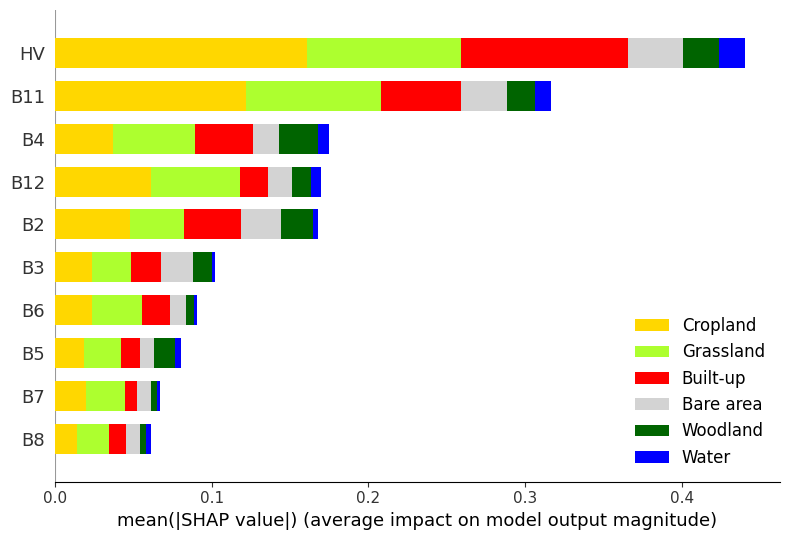

In [ ]:

from matplotlib.colors import ListedColormap

Palette = [
    '#FFD700',  # gold
    '#ADFF2F',  # greenyellow
    '#FF0000',  # red
    '#D3D3D3',  # grey
    '#006400',  # darkgreen
    '#0000FF'   # blue
]

# Create a continuous colormap from your discrete list
my_cmap = ListedColormap(Palette)

shap.summary_plot(
    shap_values,
    X_train_sample,
    feature_names=features,
    class_names=Names,
    color=my_cmap
)